# What kind of movies are you interested in watching?

## Movie Recommendation using Collaborative and Content Based Filtering 

There are two types of recommendation systems, Content-Based and Collaborative Filtering. Collaborative Filtering focuses on the similarity attribute of the users and it finds people with similar tastes based on a similarity measure from the large group of users. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In **Collaborative Filtering**, this recommendation system makes predictions of what might interest a person based on the taste of many other users. It assumes that if person X likes comedy movies, and person Y likes comedy movies and family movies, then person X might like family movies as well. There are two types of this recommender filter:

**User-User**: It identifies other people with similar tastes to a target user and combines their ratings to make recommendations for that user. 

**Item-Item**: Itidentifies global product associations from user ratings, but uses these product associations to provide personalized recommendations based on a user's own product ratings

In **Content-Based Filtering**, this recommendation system focuses on the products themselves and recommends other products that have similar attributes. It relies on the characteristics of the products themselves, so it doesn’t rely on other users to interact with the products before making a recommendation.

In this notebook, I will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.
- Background on the MovieLens dataset for recommender system.
- How to load and process the data.
- How to do exploratory data analysis.
- The 2 different types of recommendation engines.
- How to develop a collaborative filtering model based on user ratings.
- How to develop a content-based recommendation model based on movie genres.

## The MovieLens Dataset

The MovieLens datasets are full of data describing how people rate movies. As it turns out, these datasets have been useful to lots of folks, from recommender systems researchers to the readers of popular-press programming books.
It was collected by GroupLens researchers over various periods of time and by far the most popular when it comes to implementing a recommender system.  

These datasets will change over time, and are not appropriate for reporting research results. I choose to use the smallest datasets with 100,000 ratings with 9,000 movies by 700 users. They were last updated 10/2016.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import linalg as LA
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from numpy import linalg as LA

## Data Preparation

First, we begin to load the two datasets, ratings and movies. Fortunately, they were already in csv so, it was easier to load them into memory as a dataframe. 

In [2]:
ratings = pd.read_csv('ratings.csv')# read in ratings dataset
movies = pd.read_csv('movies.csv')# read in movies dataset

We need to look at the first few rows of the ratings dataframe. 

In [3]:
ratings.head() # the timestamp will not be relevant in building our recommenders later

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


There are four columns (userId, movieId, rating, timestamp) and 100,000 rows. 

In [4]:
ratings.shape

(100004, 4)

We need to look at the first few rows of the movies dataframe. 

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


There are three columns (movieId, title, genres) and 9125 rows in this dataset. 

In [6]:
movies.shape

(9125, 3)

Now both datasets have been converted to dataframes, there is commonality between the two. Noticed each of them have the movieId column. We will need to merge both of them and drop the timestamp field. 

In [7]:
combined = pd.merge(ratings,movies,how = 'inner', on = 'movieId').drop('timestamp',axis = 1)

Let's look at the merged dataframes!

In [8]:
combined.head() # both dataframes have been combined

,userId,movieId,rating,title,genres
0,1,31,2.5,Dangerous Minds (1995),Drama
1,7,31,3.0,Dangerous Minds (1995),Drama
2,31,31,4.0,Dangerous Minds (1995),Drama
3,32,31,4.0,Dangerous Minds (1995),Drama
4,36,31,3.0,Dangerous Minds (1995),Drama


In [9]:
combined.shape 

(100004, 5)

## Exploratory Data Analysis (EDA)

Since we combined both datasets, let's check to make sure there were no missing or null values. 

In [10]:
pd.isnull(combined).sum() #there were no missing values

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

Which user had the highest number of ratings? 

In [11]:
by_userId = combined.groupby('userId')['rating'].count().sort_values(ascending = False).head()
by_userId

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

User 547 had the highest number ratings with a value of 2391.

Which movie title had the highest number of ratings?

In [12]:
by_movie_title = combined.groupby('title')['rating'].count().sort_values(ascending = False).head()
by_movie_title

title
Forrest Gump (1994)                          341
Pulp Fiction (1994)                          324
Shawshank Redemption, The (1994)             311
Silence of the Lambs, The (1991)             304
Star Wars: Episode IV - A New Hope (1977)    291
Name: rating, dtype: int64

Forest Gump (1994) had the highest number of ratings with a value of 341.

Next we examine the ratings using summary statistics. Notice the highest rating is 5 and the lowest rating is 0.5. The average for the entire dataset is 3.5

In [13]:
combined['rating'].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [14]:
%matplotlib inline

Let's check out the distribution of the ratings. User's seem to give a rating of 4 on most movies. 

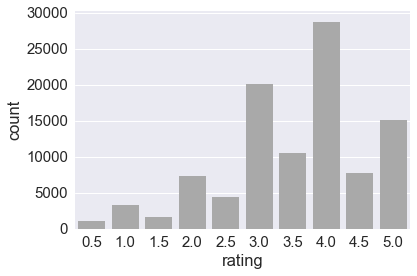

In [15]:
sns.set_style("darkgrid")
sns.set(font_scale = 1.5)
columnchart = sns.countplot(x = "rating", data = combined, color = 'DarkGrey')

Next, we can look at the most frequent words in each movie title by plotting a wordcloud visualization

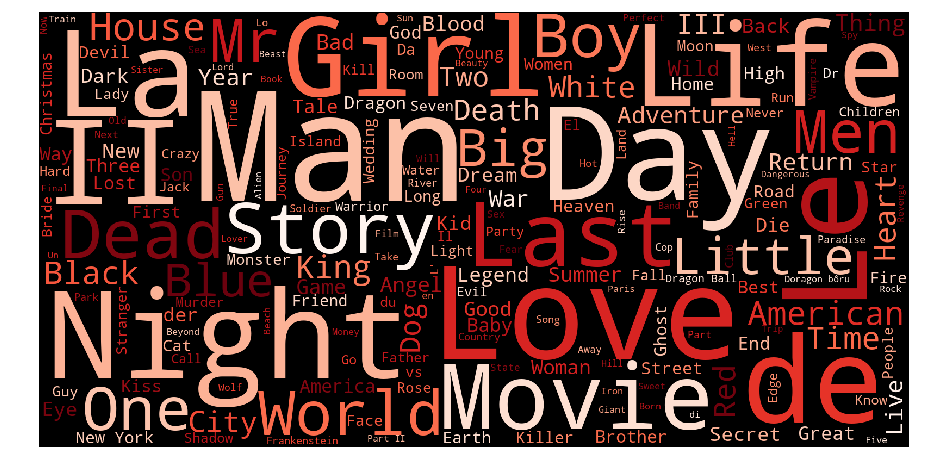

In [16]:
titles = movies['title'].fillna("").astype('str')
title = ' '.join(titles)
title_wordcloud = WordCloud(stopwords = STOPWORDS,colormap = "Reds", height = 800, width = 1600).generate(title)

#Plot the wordcloud
plt.figure(figsize = (16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The most commonly words from the movie title are: Man, Le, Love, Day, Night, La, Girl, and Life. 

## Memory-Based Collaborative Recommender Model

In order to evaluate the recommender properly, we need to split the dataset into training and testing sets. For the testing set, we only want to predict 1/4 or 25% of the ratings for the users.  

In [17]:
train, test = train_test_split(combined, test_size = 0.2)

Before calculating the similarities for each user, we need to create two matrices to put the userId, movie title, and ratings in a pivot table.

In [18]:
ratings_pivot_train = train.pivot_table(index = 'userId', columns = 'title', values = 'rating').fillna(0)
ratings_pivot_train.shape

(671, 8381)

In [19]:
ratings_pivot_test = test.pivot_table(index = 'userId', columns = 'title', values = 'rating').fillna(0)
ratings_pivot_test.shape

(671, 4852)

Here we check out the first few rows of our training pivot table. 

In [20]:
ratings_pivot_train.head() #Just wanted to make the sure ratings are present 

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zorn's Lemma (1970),"Zorro, the Gay Blade (1981)",Zulu (1964),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to find out which users gave similair ratings for each movie, we need to create a function to compute their similarities using the cosine metric. 

In [21]:
# Function to compute similarities
def cos_similarity(ratings, kind = 'user', epsilon = 1e-9):
    if kind == 'user':
        # for user-based
        sim = ratings.dot(ratings.T) + epsilon
        norms = np.array(LA.norm(ratings)*LA.norm(ratings.T))
    elif kind == 'item':
        # for item-based 
        sim = ratings.T.dot(ratings) + epsilon
        norms = np.array(LA.norm(ratings.T)*LA.norm(ratings))
    return sim/norms

Here we compute the cosine similarities for our training data for the user-user and item-item. 

In [22]:
# training data
user_similarity = cos_similarity(ratings_pivot_train.values, kind = 'user') # user-based similarities
movie_similarity = cos_similarity(ratings_pivot_train.values, kind = 'item')# item-based similarities

Here, we generate predictions using the cosine similarity matrix as weights and adjust bias for individual users' by subtracting the mean of rating.

For the user-user and item-time collaborative filter case, we will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). We also need to normalize them so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that we are trying to predict. 

In [23]:
# Function to predict ratings
def predict(ratings, similarity, kind = 'user'):
    if kind == 'user':
        user_bias = ratings.mean(axis = 1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis = 1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis = 0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

Let's predict the ratings for the user and item using the training set.

In [24]:
user_prediction = predict(ratings_pivot_train.values, user_similarity, kind = 'user')
movie_prediction = predict(ratings_pivot_train.values, movie_similarity, kind = 'item')

Here, we going to use the mean squared error function as my validation metric then substract it by 100 to get the accuracy. Then we will compare the user-user and item-item predictions to evaluate which one performed better or yielded better results.

In [25]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

### User/Item-Based Collaborative Recommender Evaluation

Now we print out the user and item based root square mean errors and their accuracies. 

In [26]:
print('User-based bias-adjusted CF RMSE: %.2f' %rmse(user_prediction, ratings_pivot_test.values))
print('Item-based bias-adjusted CF RMSE: %.2f' %rmse(movie_prediction, ratings_pivot_test.values))
print('User-based bias-adjusted CF RMSE: %.2f' %(100 - rmse(user_prediction, ratings_pivot_test.values)))
print('Item-based bias-adjusted CF RMSE: %.2f' %(100 - rmse(movie_prediction, ratings_pivot_test.values)))

User-based bias-adjusted CF RMSE: 3.55
Item-based bias-adjusted CF RMSE: 3.39
User-based bias-adjusted CF RMSE: 96.45
Item-based bias-adjusted CF RMSE: 96.61


The predicted ratings for the user-based model will be stored in a dataframe. 

In [27]:
user_based = pd.DataFrame(user_prediction,index = ratings_pivot_train.index, columns = ratings_pivot_train.columns)

In [28]:
user_based.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zorn's Lemma (1970),"Zorro, the Gay Blade (1981)",Zulu (1964),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.146677,-0.119922,-0.151299,-0.148526,-0.148526,-0.081766,0.057170,-0.053728,0.105082,-0.087929,...,-0.106467,-0.151299,-0.099945,-0.146985,0.250283,-0.145752,0.064487,0.331806,-0.132811,-0.151299
2,-0.066732,-0.053514,-0.061910,-0.067804,-0.067804,-0.038351,0.063041,-0.020464,0.100242,-0.026647,...,-0.051735,-0.063674,-0.044420,-0.054205,0.100798,-0.060314,0.076560,0.171733,-0.064674,-0.064960
3,-0.079957,-0.061813,-0.072608,-0.080453,-0.080453,-0.057314,0.058316,-0.041667,0.195709,-0.041728,...,-0.062900,-0.075438,-0.058914,-0.048119,0.114027,-0.068337,0.106521,0.148565,-0.064762,-0.074622
4,-0.036900,-0.019999,-0.028281,-0.038096,-0.038096,0.002849,0.149721,0.024938,0.184956,0.019294,...,-0.011795,-0.031965,-0.001723,-0.020505,0.191592,-0.021668,0.162080,0.325452,-0.025036,-0.037235
5,-0.074291,-0.058573,-0.068284,-0.075867,-0.075867,-0.049632,0.086686,-0.038652,0.266183,-0.022555,...,-0.050926,-0.070590,-0.041220,-0.048172,0.118673,-0.062534,0.149113,0.201610,-0.056455,-0.072901


Now we look at the predicted ratings (user-based) for movies the user has not rated yet.

In [29]:
# Predictions for movies the user 5 hasn't rated yet
user_predictions = user_based.loc[5,pd.DataFrame(ratings_pivot_train).loc[5,:] == 0]
user_top = user_predictions.sort_values(ascending = False).head(3)
user_recommendations = pd.DataFrame(data = user_top)
user_recommendations.columns = ['Predicted Rating']
print(user_recommendations)

                                  Predicted Rating
title                                             
Pulp Fiction (1994)                       2.315955
Shawshank Redemption, The (1994)          2.307362
Silence of the Lambs, The (1991)          2.143021


As we can see above, user 5 is predicted to rate the movies: Pulp Fiction (1994), Shawshank Redemption, The (1994) and Silence of the Lambs, The (1991) very low ratings compared to the mean of the overall ratings in the dataset. 

In [30]:
item_based = pd.DataFrame(movie_prediction,ratings_pivot_train.index, columns = ratings_pivot_train.columns)

In [31]:
item_based.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zorn's Lemma (1970),"Zorro, the Gay Blade (1981)",Zulu (1964),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.064463,-0.158271,-0.386549,0.076041,0.076041,-0.113341,-0.122089,-0.110157,-0.021132,-0.191965,...,-0.151409,-0.337343,-0.209220,-0.190912,-0.077847,-0.495839,-0.133787,-0.082865,-0.213141,-0.213421
2,0.054392,-0.083602,-0.199325,-0.032487,-0.032487,-0.026990,-0.024234,-0.026421,0.057394,-0.062221,...,-0.093976,-0.135322,-0.100097,-0.120863,0.008299,-0.297994,-0.034849,0.025179,-0.195882,-0.134358
3,-0.064463,-0.090004,-0.211856,-0.342564,-0.342564,-0.073151,-0.050735,-0.067457,0.073582,-0.110105,...,-0.110144,-0.167309,-0.144916,-0.071197,-0.009698,-0.268611,-0.042536,-0.014785,-0.121538,-0.102879
4,0.327217,0.120793,0.409520,-0.117758,-0.117758,0.248748,0.281886,0.219126,0.276582,0.324747,...,0.142510,0.421917,0.298663,0.047565,0.277884,0.670664,0.257804,0.403997,0.091207,-0.151195
5,0.210524,-0.019084,-0.047482,-0.094502,-0.094502,0.001511,0.062107,-0.014269,0.227074,0.062408,...,-0.006058,0.023768,0.045341,0.014489,0.076681,0.017873,0.102169,0.108943,0.032295,-0.098487


Now we look at the predicted ratings (item-based) for movies the user has not rated yet. 

In [32]:
# Predictions for movies that the user 5 hasn't rated yet
item_predictions = item_based.loc[5,pd.DataFrame(ratings_pivot_train).loc[5,:] == 0]
item_top = item_predictions.sort_values(ascending = False).head(3)
item_recommendations = pd.DataFrame(data = item_top)
item_recommendations.columns = ['Predicted Rating']
print(item_recommendations)

                                  Predicted Rating
title                                             
Shawshank Redemption, The (1994)          1.684264
Pulp Fiction (1994)                       1.646671
Silence of the Lambs, The (1991)          1.492489


As we can see above, user 5 is predicted to rate the movies: Pulp Fiction (1994), Shawshank Redemption, The (1994) and Silence of the Lambs, The (1991) very low ratings. The first two recommendations (Shawshank Redemption,Pulp Fiction (1994) The (1994)) of appeared to rated a lot lower than the user-based model above.

## Model-Based Collaborative Recommender System

In Model-Based Collaborative Recommender Systems involve building a model based on the dataset of ratings. In other words, we extract some information from the dataset, and use that as a "model" to make recommendations without having to use the complete dataset every time. For our model, we will use matrix factorization (MF) such as Singular Value Decomposition (SVD). So we are going to show you this method for faster processing when computing predictions. 

In [33]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(ratings_pivot_train, k = 24) # you can adjust the dimensionality for the rank matrix
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

### Model-Based Collaborative System Evaluation

Now we print out the model-based root square mean error along with their accuracy.

In [34]:
print('Matrix-Factorization CF RMSE: %.2f' %rmse(X_pred, ratings_pivot_test.values))
print('Matrix-Factorization CF RMSE: %.2f' %(100 - rmse(X_pred, ratings_pivot_test.values)))

Matrix-Factorization CF RMSE: 3.60
Matrix-Factorization CF RMSE: 96.40


Store all ratings for each user in a dataframe.

In [35]:
svd_based_user = pd.DataFrame(X_pred, index = ratings_pivot_train.index, columns = ratings_pivot_train.columns)

Now we look at the predicted ratings (user model-based) for movies the user has not rated yet. 

In [36]:
# Predictions for movies that the user 5 hasn't rated yet
svd_predictions = svd_based_user.loc[5,pd.DataFrame(ratings_pivot_train).loc[5,:] == 0]
svd_top = svd_predictions.sort_values(ascending = False).head(3)
svd_recommendations = pd.DataFrame(data = svd_top)
svd_recommendations.columns = ['Predicted Rating']
print(svd_recommendations)

                        Predicted Rating
title                                   
American Beauty (1999)          1.744064
Titanic (1997)                  1.597986
Finding Nemo (2003)             1.593203


For the SVD model (user-based), user 5 rated very low on movies, American Beauty (1999)), Titanic (1997, and Finding Nemo (2003)

## Content-Based Recommender System 

Let's begin by building a Content-Based Recommendation System that computes the similarity between movies based on genres. It will suggest movies that are most similar to a particular movie based on its genre. The idea is if an individual likes an item, then individual will also like a **similar** item.

In [37]:
# Break up the genres into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

Here we are going to use **TfidfVectorizer** function to transform genres to feature vectors.

**TF** stands for Term Frequency. It tells us about how often does the term you are talking about appear in the document? 

**IDF** stands for **Inverse Document Frequency**. It tells us how rare it is for a document to have this term or for a tag to be applied to the movie

In [38]:
tf = TfidfVectorizer(analyzer = 'word',ngram_range = (1, 2),min_df = 0, stop_words ='english')
movies['genres'] = movies['genres'].fillna('')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape 

(9125, 178)

Now let's compute the cosine similarity between each vector. Also, there are other metrics avaliable one can use such as: euclidean, jaccard, manhattan, and correlation. 

In [39]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.3143214 , 0.06298761, 0.05483312],
       [0.3143214 , 1.        , 0.        , 0.        ],
       [0.06298761, 0.        , 1.        , 0.35539525],
       [0.05483312, 0.        , 0.35539525, 1.        ]])

Before we can begin making movie recommendations, let's follow these steps below:

  - Get the index of the movie given its title.
  - Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
  - Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
  - Get the top 10 elements of this list. 
  - Return the titles corresponding to the indices of the top elements.

In [40]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index = movies['title']).drop_duplicates()

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title] #get indices of movies titles
    sim_scores = list(enumerate(cosine_sim[idx])) # map indices with similarities
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True) # sort from highest to lowest
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    recommendations = titles.iloc[movie_indices]# map the movie titles with indexes from the similarity scores
    for movies in recommendations[0:5]:
        #ignore duplicate recommendations same as (title)
        if movies != title:
            print(movies)

Here our recommender system had done a pretty good job finding movies with similar genres. The movie ***Toy Story (1995)*** (Animation, Children's, Comedy) had returned the top 5 movies that are most similair based on genres.

In [41]:
genre_recommendations("Toy Story (1995)")

Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
Monsters, Inc. (2001)


Here are the pros of using content-based recommendation:

 - Recommend items based on flexible features such as book title, movie description, phrases. 
 - New items can be suggested before being rated by a substantial number of users.
 - Can recommend new and unpopular items.
 
However, there are some cons of using this approach:

 - Finding the appropriate features is hard.
 - Does not recommend items outside a user's content profile.
 - Provides a limit degree of novelty, since it has to match up the features of profile and items.